# Advanced usage
J. R. Angevaare <joran.angevaare@knmi.nl>

2025 04 28

last update: 2025 04 30

## Introduction
After following the introduction example (also in this folder), there are several advanced use cases that are worth highlighting. 

## Imports, machine setup

In [1]:
import datetime
start = datetime.datetime.now()

In [2]:
import optim_esm_tools as oet
import os
import numpy as np


import matplotlib.pyplot as plt
import glob
import logging
import tempfile
import inspect
import datetime

import xarray as xr
import cdo as cdo_module
import regionmask
from optim_esm_tools.plotting.plot import setup_map
from IPython.utils import io

In [3]:
logger = oet.get_logger('EXAMPLE')
logger.setLevel(logging.WARNING)

Let's print some relevant versions

In [4]:
oet.print_versions(
    'optim_esm_tools cartopy numpy numba matplotlib'.split(), print_output=False
)

,module,version,path,git
0,python,3.8.16,/home/aangevaare/miniconda3/envs/py38/bin/python,None
1,optim_esm_tools,4.0.0,/home/aangevaare/software/optim_esm_tools/opti...,branch:advanced_examples | fc5702b
2,cartopy,0.21.0,/home/aangevaare/miniconda3/envs/py38/lib/pyth...,None
3,numpy,1.24.3,/home/aangevaare/miniconda3/envs/py38/lib/pyth...,None
4,numba,0.57.1,/home/aangevaare/miniconda3/envs/py38/lib/pyth...,None
5,matplotlib,None,/home/aangevaare/miniconda3/envs/py38/lib/pyth...,None


## 0. Data preparation

Directly copied from the example. Since everything is the same, we removed the comments

In [5]:
col = oet._test_utils.cmip_store()

In [6]:
WORK_DIR = "/data/volume_2/temp/example_notebook_v4"

if not os.path.exists(WORK_DIR):
    WORK_DIR = tempfile.mkdtemp()
    logger.warning(f"Using {WORK_DIR} you may have limited space here")

In [7]:
query = dict(
    variable_id="sos",
    table_id="Omon",
    source_id="GISS-E2-1-G",
    member_id=[
        "r2i1p5f1",
        "r1i1p5f1",
    ],
    experiment_id=[
        "piControl",
        "historical",
        "ssp245",
    ],
)

In [8]:
search = col.search(**query)

In [9]:
search.keys_info()

,activity_id,institution_id,source_id,experiment_id,table_id,grid_label
key,,,,,,
CMIP.NASA-GISS.GISS-E2-1-G.historical.Omon.gn,CMIP,NASA-GISS,GISS-E2-1-G,historical,Omon,gn
CMIP.NASA-GISS.GISS-E2-1-G.piControl.Omon.gn,CMIP,NASA-GISS,GISS-E2-1-G,piControl,Omon,gn
ScenarioMIP.NASA-GISS.GISS-E2-1-G.ssp245.Omon.gn,ScenarioMIP,NASA-GISS,GISS-E2-1-G,ssp245,Omon,gn


In [10]:
with io.capture_output() as captured:
    ddict = search.to_dataset_dict(
        xarray_open_kwargs={"use_cftime": True},
    )

04-30 12:26:48 | google.auth._default | WARNING  | Authentication failed using Compute Engine authentication due to unavailable metadata server. | _get_gce_credentials (l. 338)
04-30 12:26:48 | google.auth._default | WARNING  | Authentication failed using Compute Engine authentication due to unavailable metadata server. | _get_gce_credentials (l. 338)
04-30 12:26:48 | google.auth.compute_engine._metadata | WARNING  | Compute Engine Metadata server unavailable on attempt 1 of 5. Reason: HTTPConnectionPool(host='metadata.google.internal', port=80): Max retries exceeded with url: /computeMetadata/v1/instance/service-accounts/default/?recursive=true (Caused by NewConnectionError('<urllib3.connection.HTTPConnection object at 0x7f7acf68ae20>: Failed to establish a new connection: [Errno -2] Name or service not known')) | get (l. 205)
04-30 12:26:48 | google.auth.compute_engine._metadata | WARNING  | Compute Engine Metadata server unavailable on attempt 1 of 5. Reason: HTTPConnectionPool(host

04-30 12:26:48 | google.auth.compute_engine._metadata | WARNING  | Compute Engine Metadata server unavailable on attempt 3 of 5. Reason: HTTPConnectionPool(host='metadata.google.internal', port=80): Max retries exceeded with url: /computeMetadata/v1/instance/service-accounts/default/?recursive=true (Caused by NewConnectionError('<urllib3.connection.HTTPConnection object at 0x7f7acf64c5e0>: Failed to establish a new connection: [Errno -2] Name or service not known')) | get (l. 205)
04-30 12:26:48 | google.auth.compute_engine._metadata | WARNING  | Compute Engine Metadata server unavailable on attempt 5 of 5. Reason: HTTPConnectionPool(host='metadata.google.internal', port=80): Max retries exceeded with url: /computeMetadata/v1/instance/service-accounts/default/?recursive=true (Caused by NewConnectionError('<urllib3.connection.HTTPConnection object at 0x7f7acf6592b0>: Failed to establish a new connection: [Errno -2] Name or service not known')) | get (l. 205)
04-30 12:26:48 | google.auth

In [11]:
cdo = cdo_module.Cdo()

In [12]:
folders = {}
for key, data in ddict.items():
    folder_structure = key.split(".")
    folder_structure.insert(4, "{VARIANT_LABEL}")
    folder_structure.insert(6, "{VARIABLE_ID}")
    folder_structure.append("v20241126")

    path_fmt = os.path.join(WORK_DIR, *folder_structure)

    for variant_label in np.unique(data["member_id"]):
        ds = data.sel(member_id=variant_label)
        ds = ds.isel(dcpp_init_year=0)

        os.makedirs(
            save_in := path_fmt.format(
                VARIANT_LABEL=variant_label, VARIABLE_ID=ds.attrs["variable_id"]
            ),
            exist_ok=True,
        )

        logger.warning(f"Writing {key} to {save_in}")
        folders[f"{key}.{variant_label}"] = save_in

        if os.path.exists(yearly_file := os.path.join(save_in, "merged.nc")):
            continue
        if not os.path.exists(monthly_file := os.path.join(save_in, "monthly.nc")):
            ds.to_netcdf(monthly_file)
        cdo.yearmonmean(input=monthly_file, output=yearly_file)
        for f in monthly_file, yearly_file:
            assert os.path.exists(f), f"Missing {f}"

04-30 12:26:49 | EXAMPLE      | WARNING  | Writing CMIP.NASA-GISS.GISS-E2-1-G.piControl.Omon.gn to /data/volume_2/temp/example_notebook_v4/CMIP/NASA-GISS/GISS-E2-1-G/piControl/r1i1p5f1/Omon/sos/gn/v20241126 | <module> (l. 21)
04-30 12:26:49 | EXAMPLE      | WARNING  | Writing ScenarioMIP.NASA-GISS.GISS-E2-1-G.ssp245.Omon.gn to /data/volume_2/temp/example_notebook_v4/ScenarioMIP/NASA-GISS/GISS-E2-1-G/ssp245/r1i1p5f1/Omon/sos/gn/v20241126 | <module> (l. 21)
04-30 12:26:49 | EXAMPLE      | WARNING  | Writing ScenarioMIP.NASA-GISS.GISS-E2-1-G.ssp245.Omon.gn to /data/volume_2/temp/example_notebook_v4/ScenarioMIP/NASA-GISS/GISS-E2-1-G/ssp245/r2i1p5f1/Omon/sos/gn/v20241126 | <module> (l. 21)
04-30 12:26:49 | EXAMPLE      | WARNING  | Writing CMIP.NASA-GISS.GISS-E2-1-G.historical.Omon.gn to /data/volume_2/temp/example_notebook_v4/CMIP/NASA-GISS/GISS-E2-1-G/historical/r1i1p5f1/Omon/sos/gn/v20241126 | <module> (l. 21)
04-30 12:26:49 | EXAMPLE      | WARNING  | Writing CMIP.NASA-GISS.GISS-E2-1-G.

In [13]:
for monthly_file in glob.glob(f'{WORK_DIR}/*/*/GISS-E2-1-G/*/*/*/*/*/*/monthly.nc'):
    logger.warning(f'Removing {monthly_file} - we don\'t need it anymore')
    os.remove(monthly_file)

## Low spatial resolution for testing
Let's set the spatial resolution to a very small number (n45) such that everything runs fast and stays lightweight

In [14]:
oet.config.config.read_dict(
    {
        'analyze': {'regrid_to': 'n45', }, 
        'versions': {'cmip_handler': 'test_n45'}
        }
    )

In [15]:
# Preprocessing
ds_ssp = oet.read_ds(
    folders["ScenarioMIP.NASA-GISS.GISS-E2-1-G.ssp245.Omon.gn.r2i1p5f1"],
    add_history=False,
    max_time=None,
)
# You don't have to specify the historical path if the ESGF file-structure is followed
ds_his_ssp = oet.read_ds(
    folders["ScenarioMIP.NASA-GISS.GISS-E2-1-G.ssp245.Omon.gn.r2i1p5f1"],
    add_history=True,
    max_time=None,
)
ds_pi = oet.read_ds(
    folders["CMIP.NASA-GISS.GISS-E2-1-G.piControl.Omon.gn.r1i1p5f1"],
    add_history=False,
    max_time=None,
)

## 2. Region isolation
Let's continue from the full scale example in the example notebook

In [16]:
extra_opt = dict(
    iter_mask_min_area=1e6 * 1e6,  # m^2!,
    cluster_method="masked",
    iterable_range=dict(
        percentiles=np.linspace(99.99, 85, 61),
        product_percentiles=np.linspace(99.9, 85, 61),
        n_times_historical=np.linspace(8, 2.5, 61),
    ),
    iter_mask_max_area=999e12,
    force_continuity=True,
)


In [17]:
masks_per_method = {}
for method in oet.utils.tqdm(
    [
        oet.region_finding.IterProductPercentiles,
        oet.region_finding.IterPercentiles,
        oet.region_finding.IterLocalHistory,
        oet.region_finding.IterStartEnd,
    ]
):
    kw = dict(
        variable=None,
        data_set=ds_ssp,
        save_kw=dict(
            skip=True,
            save_in="./",
            file_types=("png",),
            sub_dir=None,
        ),
        extra_opt=extra_opt,
    )
    if "data_set_pic" in inspect.getfullargspec(method.__init__).kwonlyargs:
        kw.update(
            data_set_pic=ds_pi,
        )
    worker = method(**kw)
    masks_and_clusters = worker.get_masks()
    masks_from_this_method, _ = worker.filter_masks_and_clusters(masks_and_clusters)
    masks_per_method[method.__name__] = masks_from_this_method
    print(f"{method.__name__:30} finds {len(masks_from_this_method)} masks")


  0%|          | 0/4 [00:00<?, ?it/s]

IterProductPercentiles         finds 5 masks
IterPercentiles                finds 7 masks
IterLocalHistory               finds 3 masks
IterStartEnd                   finds 9 masks


In [18]:
def overlay_mask(mask: xr.DataArray, add_label=False, fill=False, **kw):
    """Overlay contours on a geoaxis"""
    for k, v in dict(
        linewidths=2,
        colors="k",
        levels=[0, 2],
        transform=oet.plotting.plot.get_cartopy_transform("PlateCarree"),
    ).items():
        kw.setdefault(k, v)
    CS = [plt.contour, plt.contourf][int(fill)](mask.lon, mask.lat, mask.values, **kw)
    if add_label:
        plt.gca().clabel(CS, inline=True, fontsize=3)
    return CS


## Understanding each of the four region - finding methods

### IterStartEnd
We select regions based on the difference between the start and the end of the time series. We iteratively select regions that above the percentile thresholds (see `iterable_range` above)

Let's first look at the 2D map of the difference of the start and end of the dataset

Text(0.5, 0.93, 'start end difference')

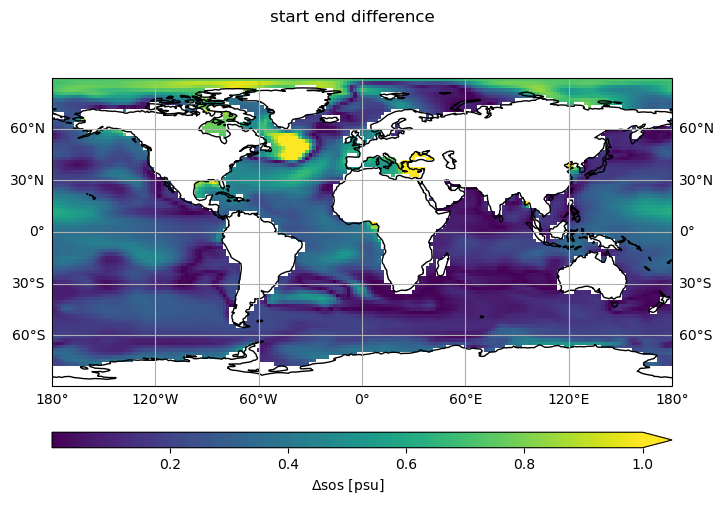

In [19]:
plt.figure(dpi=100, figsize=(8, 6))
oet.plotting.plot.plot_da(
    ds_ssp["start end difference"],
    projection="PlateCarree",
    cbar_kwargs=dict(
        orientation="horizontal",
        label="$\Delta \mathrm{sos}$ [psu]",
        pad=0.1,
        aspect=40,
    ),
    vmax=1,
)

plt.suptitle("start end difference", y=0.93)

Now, let's overlay the masks from this method

Text(0.5, 0.93, 'IterStartEnd')

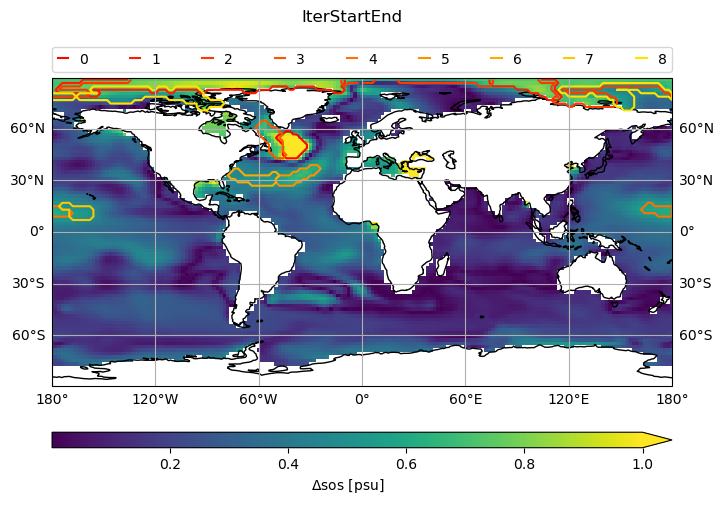

In [20]:
plt.figure(dpi=100, figsize=(8, 6))
oet.plotting.plot.plot_da(
    ds_ssp["start end difference"],
    projection="PlateCarree",
    cbar_kwargs=dict(
        orientation="horizontal",
        label="$\Delta \mathrm{sos}$ [psu]",
        pad=0.1,
        aspect=40,
    ),
    vmax=1,
)

buff = ds_ssp["start end difference"].copy().load().astype(np.float32)

method = "IterStartEnd"
nm = len(masks_per_method[method])
cc = [plt.cm.autumn(i / (nm)) for i in range(nm)]
for i, m in enumerate(masks_per_method[method]):
    buff.data[:] = np.nan
    buff.data[m] = 1
    overlay_mask(buff > 0, colors=[cc[i]], linewidths=1.5, levels=[0, 2])
    plt.plot([], [], c=cc[i], label=i)
plt.legend(**oet.plotting.plot_utils.legend_kw(ncol=10, handlelength=0.75))
plt.suptitle(method, y=0.93)


The second method uses the max-jump and standard deviation of the scenario time series:

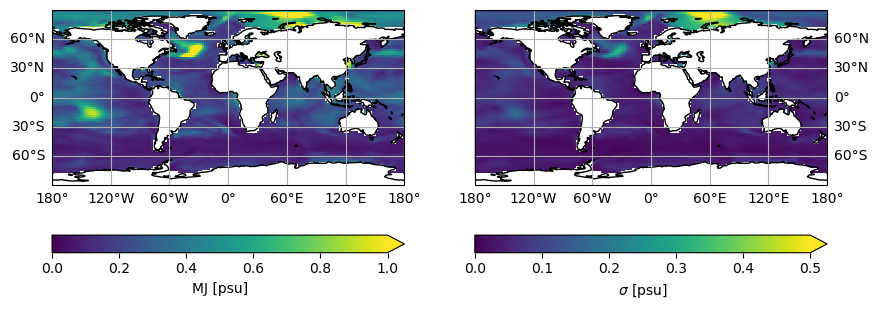

In [21]:
plt.figure(
    figsize=(10, 13),
    dpi=100,
)
ax_left, gl = setup_map(121, projection="PlateCarree")
gl.right_labels = False
ds_ssp["max jump"].plot(
    ax=ax_left,
    transform=oet.plotting.plot.get_cartopy_transform(),
    cbar_kwargs=dict(orientation="horizontal", label="MJ [psu]", pad=0.05, aspect=20),
    vmax=1,
    vmin=0,
)

ax_right, gl = setup_map(122, projection="PlateCarree")
gl.left_labels = False
ds_ssp["std detrended"].plot(
    ax=ax_right,
    transform=oet.plotting.plot.get_cartopy_transform(),
    cbar_kwargs=dict(
        orientation="horizontal", label="$\sigma$ [psu]", pad=0.05, aspect=20
    ),
    vmax=0.5,
    vmin=0.0,
)


From which we select those regions that are surpassing the percentile thresholds (for both metrics)

Text(0.5, 0.46, 'IterPercentiles')

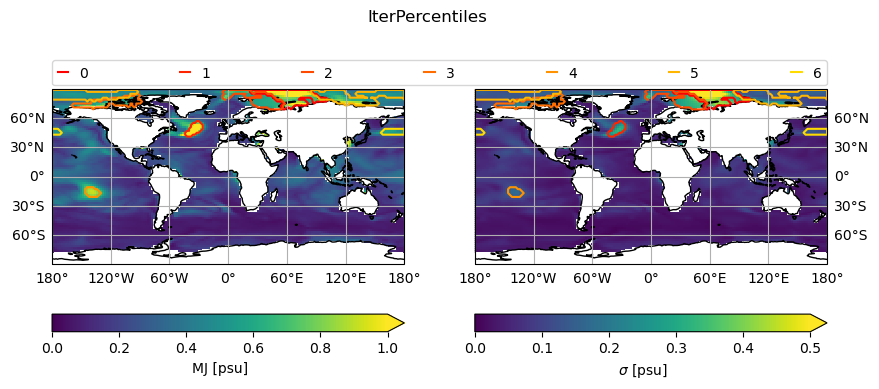

In [22]:
plt.figure(
    figsize=(10, 13),
    dpi=100,
)
ax_left, gl = setup_map(121, projection="PlateCarree")
gl.right_labels = False
ds_ssp["max jump"].plot(
    ax=ax_left,
    transform=oet.plotting.plot.get_cartopy_transform(),
    cbar_kwargs=dict(orientation="horizontal", label="MJ [psu]", pad=0.05, aspect=20),
    vmax=1,
    vmin=0,
)
#                    per_subplot_kw=dict(a=_kw, b=_kw))
ax_right, gl = setup_map(122, projection="PlateCarree")
gl.left_labels = False
ds_ssp["std detrended"].plot(
    ax=ax_right,
    transform=oet.plotting.plot.get_cartopy_transform(),
    cbar_kwargs=dict(
        orientation="horizontal", label="$\sigma$ [psu]", pad=0.05, aspect=20
    ),
    vmax=0.5,
    vmin=0.0,
)

method = "IterPercentiles"
nm = len(masks_per_method[method])
cc = [plt.cm.autumn(i / (nm)) for i in range(nm)]
for i, m in enumerate(masks_per_method[method]):
    buff.data[:] = np.nan
    buff.data[m] = 1
    for ax in [ax_left, ax_right]:
        plt.sca(ax)
        overlay_mask(buff > 0, colors=[cc[i]], linewidths=1.5, levels=[0, 2])
        plt.plot([], [], c=cc[i], label=i)
ax_left.legend(
    **oet.plotting.plot_utils.legend_kw(
        ncol=10, handlelength=0.75, bbox_to_anchor=(0, 1.02, 2.2, 0.01)
    )
)
plt.suptitle(method, y=0.46)


`IterProductPercentiles` works very similar, but takes the product of the percentiles of each metric, which then has to pass the threshold. This yields very similar results to the `IterPercentiles` method:

Text(0.5, 0.46, 'IterProductPercentiles')

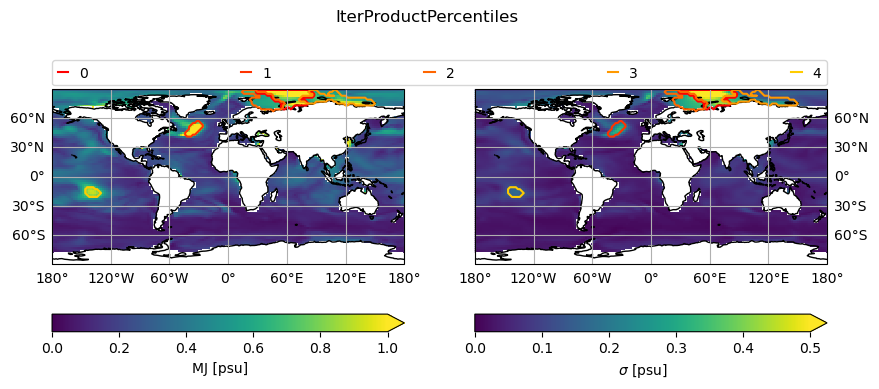

In [23]:
plt.figure(
    figsize=(10, 13),
    dpi=100,
)
ax_left, gl = setup_map(121, projection="PlateCarree")
gl.right_labels = False
ds_ssp["max jump"].plot(
    ax=ax_left,
    transform=oet.plotting.plot.get_cartopy_transform(),
    cbar_kwargs=dict(orientation="horizontal", label="MJ [psu]", pad=0.05, aspect=20),
    vmax=1,
    vmin=0,
)
ax_right, gl = setup_map(122, projection="PlateCarree")
gl.left_labels = False
ds_ssp["std detrended"].plot(
    ax=ax_right,
    transform=oet.plotting.plot.get_cartopy_transform(),
    cbar_kwargs=dict(
        orientation="horizontal", label="$\sigma$ [psu]", pad=0.05, aspect=20
    ),
    vmax=0.5,
    vmin=0.0,
)

method = "IterProductPercentiles"
nm = len(masks_per_method[method])
cc = [plt.cm.autumn(i / (nm)) for i in range(nm)]
for i, m in enumerate(masks_per_method[method]):
    buff.data[:] = np.nan
    buff.data[m] = 1
    for ax in [ax_left, ax_right]:
        plt.sca(ax)
        overlay_mask(buff > 0, colors=[cc[i]], linewidths=1.5, levels=[0, 2])
        plt.plot([], [], c=cc[i], label=i)
ax_left.legend(
    **oet.plotting.plot_utils.legend_kw(
        ncol=10, handlelength=0.75, bbox_to_anchor=(0, 1.02, 2.2, 0.01)
    )
)
plt.suptitle(method, y=0.46)


Finally `IterLocalHistory` compares the metric used above to compare the dataset to the pi-control dataset. We divide both metrics by the values in the pi-control dataset to thereby understand if something extreme is going on compared to the pi-control

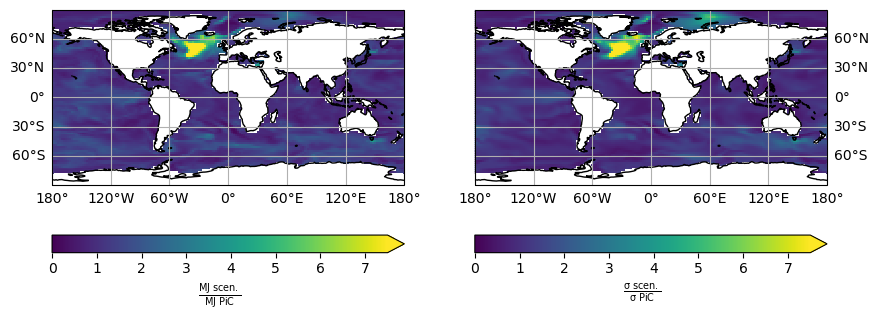

In [24]:
plt.figure(
    figsize=(10, 13),
    dpi=100,
)
ax_left, gl = setup_map(121, projection="PlateCarree")
gl.right_labels = False
(ds_ssp["max jump"] / ds_pi["max jump"]).plot(
    ax=ax_left,
    transform=oet.plotting.plot.get_cartopy_transform(),
    cbar_kwargs=dict(
        orientation="horizontal",
        label=r"$\frac{\mathrm{MJ~scen.}}{\mathrm{MJ~PiC}}$",
        pad=0.05,
        aspect=20,
    ),
    vmax=7.5,
    vmin=0,
)

ax_right, gl = setup_map(122, projection="PlateCarree")
gl.left_labels = False
(ds_ssp["std detrended"] / ds_pi["std detrended"]).plot(
    ax=ax_right,
    transform=oet.plotting.plot.get_cartopy_transform(),
    cbar_kwargs=dict(
        orientation="horizontal",
        label=r"$\frac{\mathrm{\sigma~scen.}}{\mathrm{\sigma~PiC}}$",
        pad=0.05,
        aspect=20,
    ),
    vmax=7.5,
    vmin=0.0,
)


Which similarly has to be above the values specified in the config above, below we show the results of this selection method:

Text(0.5, 0.46, 'IterLocalHistory')

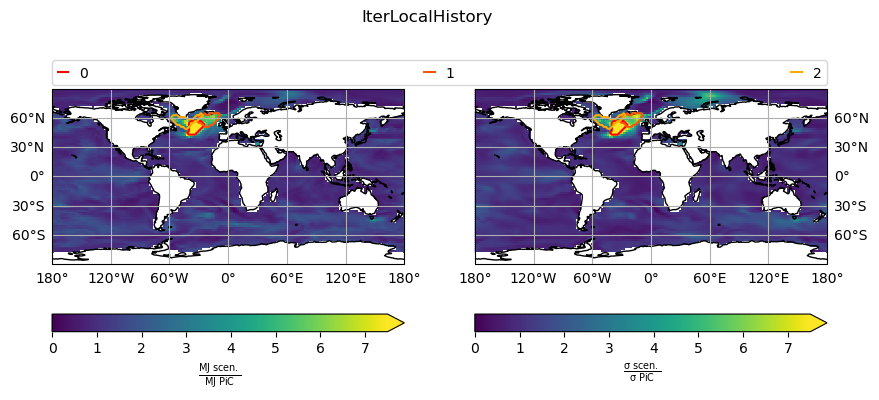

In [25]:
plt.figure(
    figsize=(10, 13),
    dpi=100,
)
ax_left, gl = setup_map(121, projection="PlateCarree")
gl.right_labels = False
(ds_ssp["max jump"] / ds_pi["max jump"]).plot(
    ax=ax_left,
    transform=oet.plotting.plot.get_cartopy_transform(),
    cbar_kwargs=dict(
        orientation="horizontal",
        label=r"$\frac{\mathrm{MJ~scen.}}{\mathrm{MJ~PiC}}$",
        pad=0.05,
        aspect=20,
    ),
    vmax=7.5,
    vmin=0,
)
#                    per_subplot_kw=dict(a=_kw, b=_kw))
ax_right, gl = setup_map(122, projection="PlateCarree")
gl.left_labels = False
(ds_ssp["std detrended"] / ds_pi["std detrended"]).plot(
    ax=ax_right,
    transform=oet.plotting.plot.get_cartopy_transform(),
    cbar_kwargs=dict(
        orientation="horizontal",
        label=r"$\frac{\mathrm{\sigma~scen.}}{\mathrm{\sigma~PiC}}$",
        pad=0.05,
        aspect=20,
    ),
    vmax=7.5,
    vmin=0.0,
)

buff = ds_ssp["start end difference"].copy().load()

method = "IterLocalHistory"
nm = len(masks_per_method[method])
cc = [plt.cm.autumn(i / (nm)) for i in range(nm)]
for i, m in enumerate(masks_per_method[method]):
    buff.data[:] = np.nan
    buff.data[m] = 1
    for ax in [ax_left, ax_right]:
        plt.sca(ax)
        overlay_mask(buff > 0, colors=[cc[i]], linewidths=1.5, levels=[0, 2])
        plt.plot([], [], c=cc[i], label=i)
ax_left.legend(
    **oet.plotting.plot_utils.legend_kw(
        ncol=10, handlelength=0.75, bbox_to_anchor=(0, 1.02, 2.2, 0.01)
    )
)
plt.suptitle(method, y=0.46)


### Combined number of regions
Below we show that the four methods found 24 regions in total, which sometimes overlap.

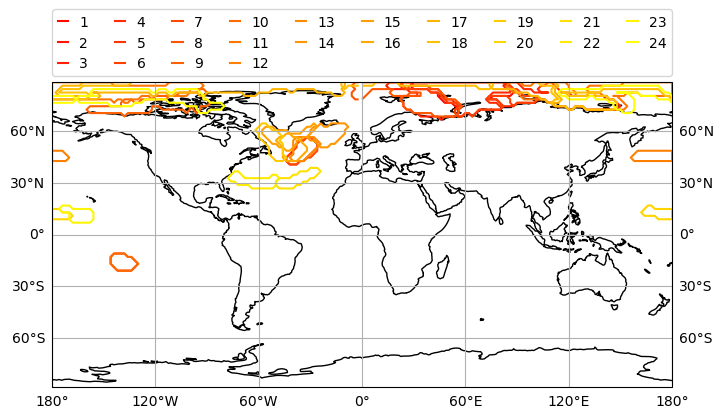

In [26]:
plt.figure(dpi=100, figsize=(8, 6))
oet.plotting.plot.setup_map(
    projection="PlateCarree",
)

buff = ds_ssp["start end difference"].copy().load().astype(np.float64)

nm = sum(len(x) for x in masks_per_method.values())
cc = [plt.cm.autumn(i / (nm)) for i in range(nm + 1)]
i = 0
for ml in masks_per_method.values():
    for m in ml:
        i += 1
        buff.data[:] = np.nan
        buff.data[m] = 1
        overlay_mask(buff > 0, colors=[cc[i]], linewidths=1.5, levels=[0, 2])
        plt.plot([], [], c=cc[i], label=i)
plt.legend(**oet.plotting.plot_utils.legend_kw(ncol=10, handlelength=0.75))


just looking at the spatially averaged time series does not clearly show which of these regions are most extreme, and this is where te statistical criteria come in.

Text(0, 0.5, 'SSS [0.01]')

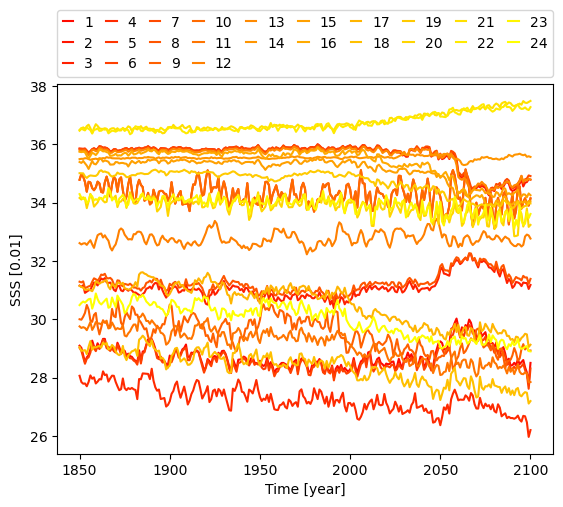

In [27]:
i = 0

a = ds_his_ssp[ds_his_ssp.variable_id].values
t = oet.analyze.xarray_tools.set_time_int(ds_his_ssp)["time"]
for ml in masks_per_method.values():
    for m in ml:
        i += 1
        b = a.copy()
        b[:, ~m] = np.nan
        wy = oet.analyze.tools._weighted_mean_3d_numba(
            b, ds_his_ssp["cell_area"].values
        )

        plt.plot(t, wy, c=cc[i], label=i)
plt.legend(**oet.plotting.plot_utils.legend_kw(ncol=10, handlelength=0.75))
plt.xlabel("Time [year]")
plt.ylabel("SSS [0.01]")


### Formal criteria

In [28]:
def crit_A_2024_04_trop_domain(
    max_jump,
    J2_rm,
    J2_min0_rm,
    p_dip,
    mj_std_trop_domain,
    mj_pi_std_trop_domain,
    **kw,
):
    _J2_abs = min(J2_rm, abs(J2_min0_rm))
    return (
        (max_jump > 4.5)
        & (p_dip < 0.01)
        & (_J2_abs > 3)
        & (max(J2_rm, abs(J2_min0_rm)) > 4.5)
        & (mj_std_trop_domain > 5.0)
        & (mj_pi_std_trop_domain > 10)
    )


def crit_D_2025_02(
    se_vs_se_trop,
    se_pi_std,
    se_pi_std_trop_domain,
    rho10_50,
    variable_id,
    **kw,
) -> bool:
    return (
        all(k not in variable_id for k in ["siconc", "siconca", "mlotst"])
        & (se_pi_std > 50)
        & (rho10_50 > 40)
        & (se_pi_std_trop_domain > 60)
        & (abs(se_vs_se_trop) > 4))


# We can combine the two criteria in one single criterium that checks if either is True
def passes_2025(**kw):
    return any(
        p(**kw)
        for p in (
            crit_A_2024_04_trop_domain,
            crit_D_2025_02,
        )
    )

## 4. Full-scale workflow

The example above is simple and fast to run, we will now will reproduce the setup also used in `2024_11_11_dramatic_shifts_v17_compressed.pdf`.

First we need to setup the config for the region finding:

In [29]:
masks = [mm for m in masks_per_method.values() for mm in m]
len(masks)

24

### Merge the masks
Now we merge the masks if at least one of the masks is passing and the combination will also pass the criteria. The idea is similar to before.

In [30]:
merger = oet.analyze.merge_candidate_regions.MergerCached(
    pass_criteria=passes_2025,
    summary_calculation=oet.analyze.region_calculation.summarize_stats,
    data_sets=[
        oet.analyze.xarray_tools.mask_to_reduced_dataset(ds_his_ssp, mask)
        for mask in masks
    ],
    common_mother=ds_his_ssp,
    common_pi=ds_pi,
)

In [32]:
oet.get_logger().setLevel("ERROR")
merger.set_passing_largest_data_sets_first()
merged = merger.merge_datasets()
oet.get_logger().setLevel("WARNING")

Looping candidates:   0%|          | 0/24 [00:00<?, ?it/s]

checking at least one passes:   0%|          | 0/7 [00:00<?, ?it/s]

merging iteratively:   0%|          | 0/23 [00:00<?, ?it/s]

In [33]:
len(merged)

1

In [34]:
assert len(merged), "This example is not complete since we don't have a passing example"

### Check the merged 

which regions were used in the final dataset?

IterLocalHistory
IterLocalHistory
IterStartEnd


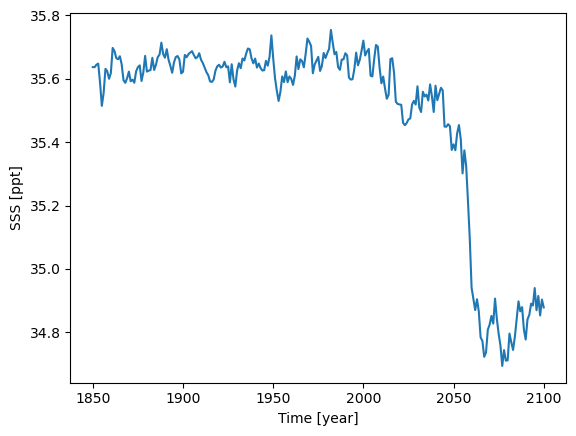

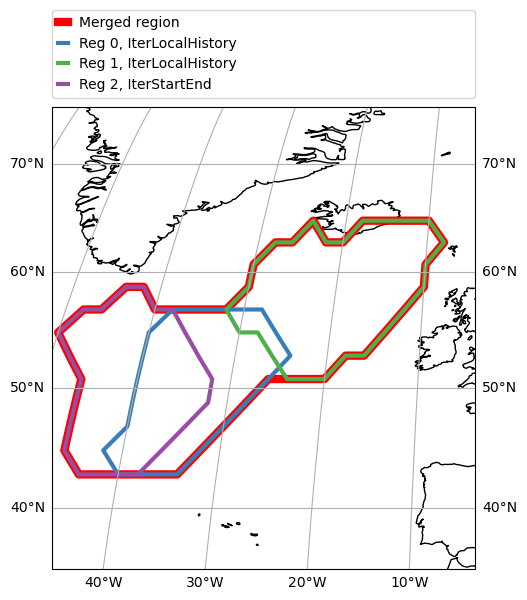

In [35]:
mf = merged[0]["ds"]["global_mask"].values
sources = []
for meth, ml in masks_per_method.items():
    for mm in ml:
        if (mm & mf).sum() == mm.sum():
            print(meth)
            sources.append([meth, mm])
plt.plot(
    merged[0]["ds"]["time"].values,
    oet.analyze.tools._weighted_mean_3d_numba(
        merged[0]["ds"]["sos"].values, merged[0]["ds"]["cell_area"].values
    ),
)
plt.ylabel("SSS [ppt]")
plt.xlabel("Time [year]")
plt.show()
plt.figure(dpi=100, figsize=(8, 6))
oet.plotting.plot.setup_map(
    projection="Robinson",
)

buff = oet.analyze.xarray_tools.reverse_name_mask_coords(
    merged[0]["ds"]["global_mask"].astype(np.float64)
)
overlay_mask(buff > 0, colors=["r"], linewidths=6, levels=[0, 2])
plt.plot([], [], c="r", label="Merged region", lw=6)

cc = oet.plot_utils.get_plt_colors()[1:]
for i, (meth, mask) in enumerate(sources):
    c = cc[i]
    buff.data = mask
    overlay_mask(buff > 0, colors=[c], linewidths=3, levels=[0, 2])
    plt.plot([], [], c=c, label=f"Reg {i}, {meth}", lw=3)

plt.legend(**oet.plotting.plot_utils.legend_kw(ncol=1, handlelength=0.75))
plt.gca().set_extent([315, 355, 35, 75])



### Adding many small-scale submasks

Similar to the initial example, we now add a set for small scale regions. Additionally we are going to investigate how the merger step resolves the merges.

In [36]:
kw_small = kw.copy()
kw_small['extra_opt'].update(dict(step_size=3))
small_masks, _ = oet.region_finding.MaskAll(**kw_small).get_masks()

In [37]:
large_regions = [
    oet.analyze.xarray_tools.mask_to_reduced_dataset(ds_his_ssp, mask) for mask in masks
]
small_regions = [
    oet.analyze.xarray_tools.mask_to_reduced_dataset(ds_his_ssp, mask) for mask in small_masks
]

Add some utils to plot intermediate masks

In [38]:
land = regionmask.defined_regions.natural_earth_v5_0_0.land_110.mask(ds_his_ssp['cell_area'])

In [ ]:
os.makedirs(save_mask_plots_in:= os.path.join(WORK_DIR, 'masks', ), exist_ok=True)
if os.listdir(save_mask_plots_in):
    # Start with an empty folder:
    !rm $save_mask_plots_in/*

In [40]:
class MergerCachedWithSave(oet.analyze.merge_candidate_regions.MergerCached):
    def cache_summary(self, mask, *a, **kw) -> str:
        """Modify MergerCached.cache_summary to also save a plot in the "save_mask_plots_in" folder"""
        key = self.hash_for_mask(mask)
        if key not in self._cache:
            self.log.warning(f"Loading {key} new. Tot size {len(self._cache.keys())}")
            self._cache[key] = self._summary_calculation(*a, **kw, mask=mask)

            # Add a simple plotting routine
            land.plot(add_colorbar=False)
            plt.imshow(mask, extent=[0, 360, -90, 90])

            mask_n = len(os.listdir(save_mask_plots_in))
            plt.title(f"{mask_n} pass={self.pass_criteria(**self._cache[key])}")
            plt.savefig(
                os.path.join(save_mask_plots_in, f"mask_{mask_n:06}.png"), dpi=100
            )
            plt.clf()

        return self._cache[key]


Run the Merger now with the intermediate caching of masks to be evaluated. We will then inspect the iterative process involved in merging these regions

In [41]:
merger = MergerCachedWithSave(
    pass_criteria=passes_2025,
    summary_calculation=oet.analyze.region_calculation.summarize_stats,
    data_sets=large_regions + small_regions,
    common_mother=ds_his_ssp,
    common_pi=ds_pi,
)

In [43]:
oet.get_logger().setLevel("ERROR")
merger.set_all_caches_as_false(small_masks)
merged = merger.merge_datasets()
oet.get_logger().setLevel("WARNING")

Looping candidates:   0%|          | 0/1285 [00:00<?, ?it/s]

checking at least one passes:   0%|          | 0/1260 [00:00<?, ?it/s]

merging iteratively:   0%|          | 0/1284 [00:00<?, ?it/s]

<Figure size 640x480 with 0 Axes>

We can now see that the region has slightly been increased compared to the plot above


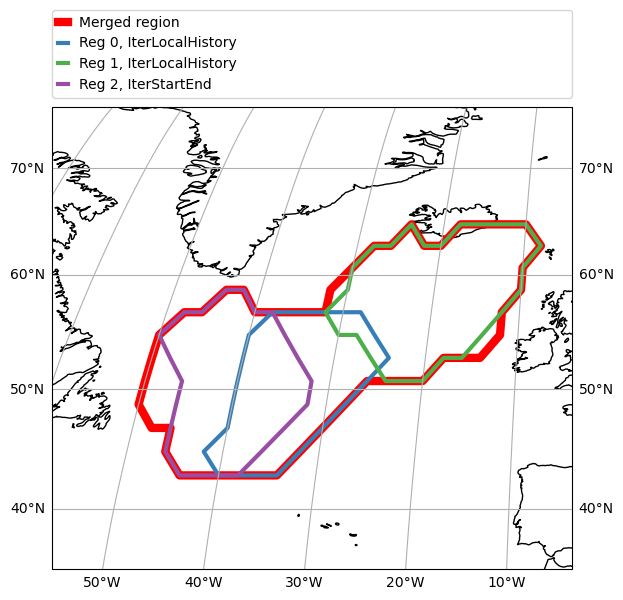

In [44]:
plt.figure(dpi=100, figsize=(8, 6))
oet.plotting.plot.setup_map(
    projection="Robinson",
)

buff = oet.analyze.xarray_tools.reverse_name_mask_coords(
    merged[0]["ds"]["global_mask"].astype(np.float64)
)

overlay_mask(buff > 0, colors=["r"], linewidths=6, levels=[0, 2])
plt.plot([], [], c="r", label="Merged region", lw=6)

cc = oet.plot_utils.get_plt_colors()[1:]
for i, (meth, mask) in enumerate(sources):
    c = cc[i]
    buff.data = mask
    overlay_mask(buff > 0, colors=[c], linewidths=3, levels=[0, 2])
    plt.plot([], [], c=c, label=f"Reg {i}, {meth}", lw=3)

plt.legend(**oet.plotting.plot_utils.legend_kw(ncol=1, handlelength=0.75))
plt.gca().set_extent([305, 355, 35, 75])


### Inspect merging iterative process

Below we merge al the cached mask files that the Merger tries resolving to see if a merged region also passes the criteria. As you can see from the `gif` file below, the Merger tries merging regions in the following order:
 1. Passing regions first, than regions that do not pass.
 2. Big regions first, than small
 3. Latitude from high to low
 4. Longitude from west to east

In [45]:
try:
    import imageio.v3 as imageio
except (ImportError, ModuleNotFoundError):
    ...
else:
    print('write gif')
    images = []
    for file in sorted(glob.glob(os.path.join(save_mask_plots_in, '*.png'))):
        images.append(imageio.imread(file))
    imageio.imwrite('mask.gif', images, fps=5)

write gif


## Gif of iterative masking.
In case you have `imageio` installed, you just wrote a gif file that shows the iterative process wherein the Merger tries resolving the candidates.
First, the 24 regions that we found above are evaluated in random order. That are the first 24 iterations.

Then, it starts working on the regions that are passing, which we can merge. Then, we start merging the small regions that we added as the `small_regions` above. We recognize the order discussed above.

![Mask gif](mask.gif "masking iteration gif")

In [46]:
end = datetime.datetime.now()

In [47]:
print(f'Started at {start}, finished at {end}')
dt = end - start
print(f'Took {dt.total_seconds()/60:.1f} m')

Started at 2025-04-30 12:26:42.137681, finished at 2025-04-30 12:28:11.326217
Took 1.5 m
